Connect Google Drive

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download Ul ultralytics

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

## Import Dataset

In [4]:
%cd /content/drive/MyDrive/AI_Human_Detection/

!curl -L "https://app.roboflow.com/ds/ePytQzrTOx?key=EW8Eaftnmr" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

%ls -la

/content/drive/MyDrive/AI_Human_Detection
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   3298      0 --:--:-- --:--:-- --:--:--  3307
100 39.7M  100 39.7M    0     0  49.7M      0 --:--:-- --:--:-- --:--:--  131M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/240920g3tlq_png.rf.d42eb781a170ccfe9f4d7b67ed9f640e.jpg  
 extracting: test/images/3bceba295cdba9ee8f3b8c2452bb29cf_jpg.rf.ff9b2cfbf7caf340a02ef810554bc454.jpg  
 extracting: test/images/40964969-86f5-4545-a0c9-aa2918b0f443___CR0-0-970-600_PT0_SX970_V1____jpg.rf.e493ec0e6ea355027a296a28af8e4647.jpg  
 extracting: test/images/565000004404701_jpeg.rf.08123dd3259b2f5c8eef412d542d60de.jpg  
 extracting: test/images/Image_28_jpg.rf.5d3f

import ENV

In [5]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image


# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()



## Visualize a few training images.

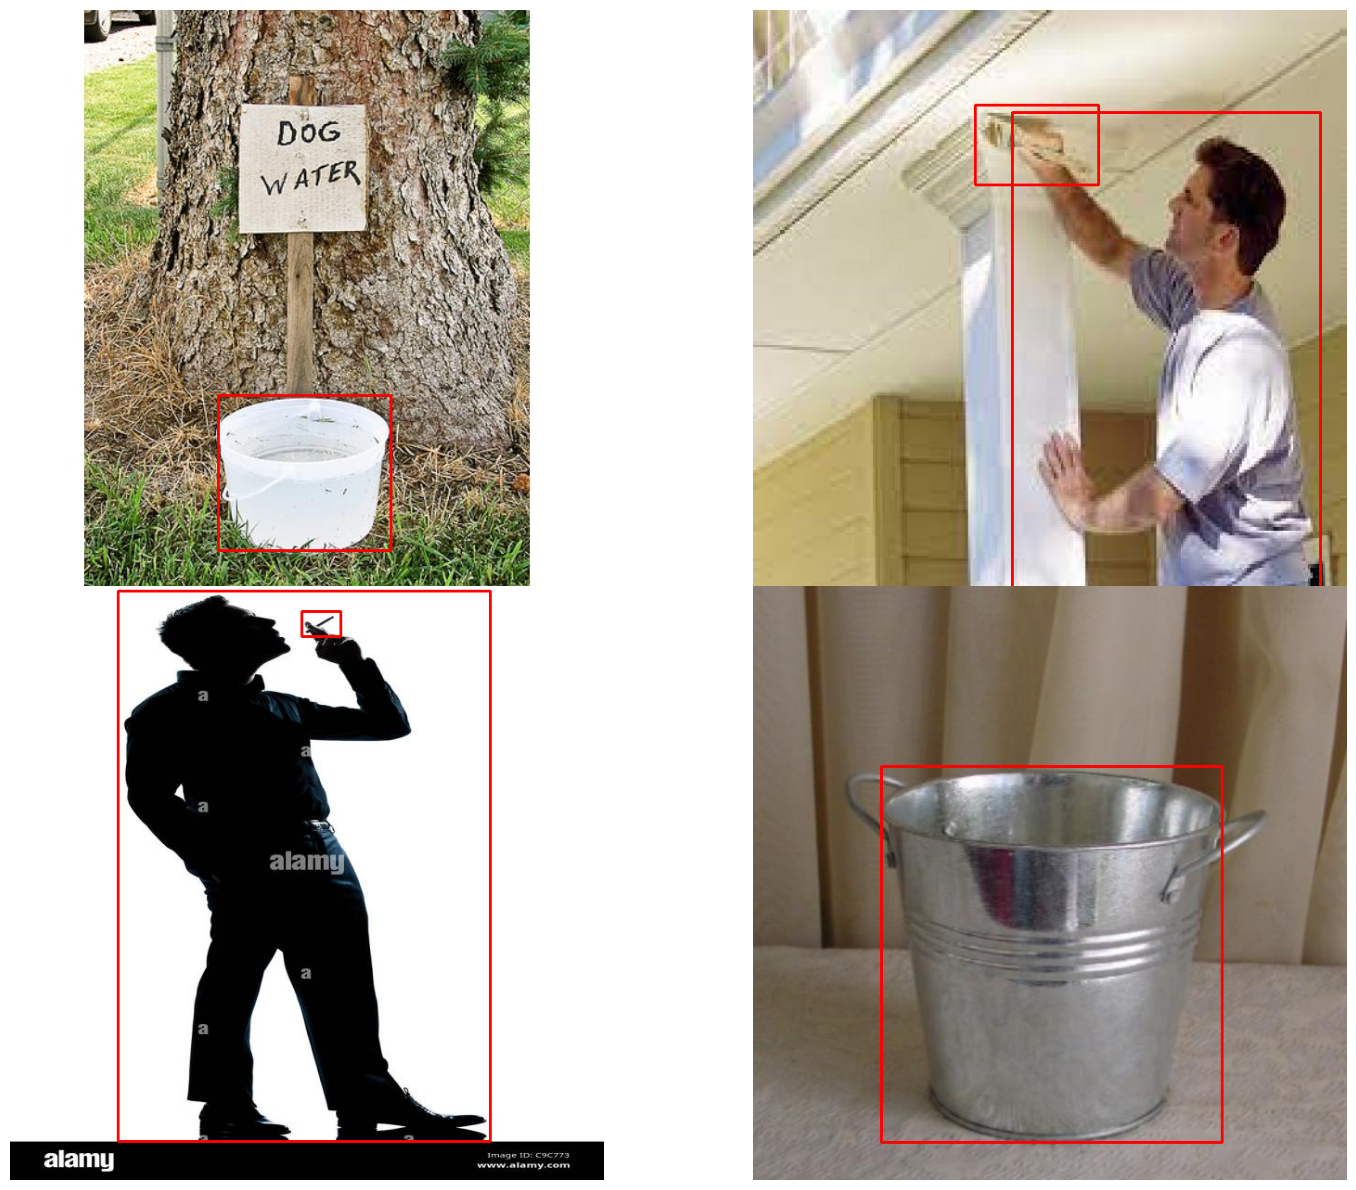

In [6]:
# Visualize a few training images.
plot(
    image_paths='/content/drive/MyDrive/AI_Human_Detection/train/images/',
    label_paths='/content/drive/MyDrive/AI_Human_Detection/train/labels/',
    num_samples=4,
)

## Training Model

In [9]:
# 1st
# Sample training for 5 epoch.
EPOCHS = 50
!yolo task=detect mode=train model=yolov8s.pt imgsz=1280 data=/content/drive/MyDrive/AI_Human_Detection/data.yaml epochs={EPOCHS} batch=16 name=yolov8n_v8_50e lr0=0.01


Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/AI_Human_Detection/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

In [10]:
# 2st
# Sample training for 5 epoch.
EPOCHS = 100
!yolo task=detect mode=train model=yolov8s.pt imgsz=1280 data=/content/drive/MyDrive/AI_Human_Detection/data.yaml epochs={EPOCHS} batch=16 name=yolov8n_v8_50e lr0=0.01


Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/AI_Human_Detection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

In [11]:
# 3st
# Sample training for 5 epoch.
EPOCHS = 100
!yolo task=detect mode=train model=yolov8s.pt imgsz=1280 data=/content/drive/MyDrive/AI_Human_Detection/data.yaml epochs={EPOCHS} batch=32 name=yolov8n_v8_50e lr0=0.001


Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/AI_Human_Detection/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

In [12]:
# ​4st
# Sample training for 5 epoch.
EPOCHS = 150
!yolo task=detect mode=train model=yolov8s.pt imgsz=1280 data=/content/drive/MyDrive/AI_Human_Detection/data.yaml epochs={EPOCHS} batch=32 name=yolov8n_v8_50e lr0=0.01


Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/AI_Human_Detection/data.yaml, epochs=150, time=None, patience=100, batch=32, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

## Validation Model

In [14]:
!yolo task=detect mode=val model=/content/drive/MyDrive/AI_Human_Detection/runs/detect/yolov8n_v8_50e4/weights/best.pt name=yolov8n_eval data=/content/drive/MyDrive/AI_Human_Detection/data.yaml

Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/MyDrive/AI_Human_Detection/valid/labels.cache... 197 images, 0 backgrounds, 0 corrupt: 100% 197/197 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:04<00:00,  2.81it/s]
                   all        197        382      0.705       0.49      0.546      0.299
                 brush         29         34      0.745      0.353      0.461      0.254
                bucket         80        104      0.839      0.652       0.75      0.553
             cigarette         26         28      0.514       0.25      0.269      0.108
                person         80        116      0.763      0.748      0.775      0.433
                roller         27         30       0.83      0.467      0.584      0.309
                 

## Test Model

In [ ]:
## !yolo task=detect mode=predict model=/content/drive/MyDrive/AI_Human_Detection/runs/detect/yolov8n_v8_50e4/weights/best.pt name=yolov8n_predict data=/content/drive/MyDrive/AI_Human_Detection/data.yaml

## Prediction Test Image

In [18]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
from ultralytics import YOLO
import os

# โหลดโมเดลที่เทรนเสร็จแล้ว
model = YOLO("/content/drive/MyDrive/AI_Human_Detection/runs/detect/yolov8n_v8_50e4/weights/best.pt")  # เปลี่ยน path ตามที่อยู่ของโมเดล
conf_threshold = 0.8  # ค่าความมั่นใจที่ใช้สำหรับกรองผลทำนาย

# โฟลเดอร์ที่เก็บภาพ
input_folder = "/content/DataTest/"  # เปลี่ยน path ตามที่อยู่ของโฟลเดอร์ภาพ

# อ่านภาพทั้งหมดในโฟลเดอร์
image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# ทำนายภาพในโฟลเดอร์และแสดงผล
for img_file in image_files:
    img_path = os.path.join(input_folder, img_file)

    # ทำนายภาพ
    results = model.predict(img_path, conf=conf_threshold)

    # แสดงผลลัพธ์
    for result in results:
        # อ่านภาพต้นฉบับ
        img = cv2.imread(img_path)
        boxes = result.boxes  # เอากล่องที่ทำนายได้
        for box in boxes:
            # ดึงข้อมูลกล่องและ label
            xyxy = box.xyxy[0].cpu().numpy().astype(int)  # พิกัดของ bounding box
            class_id = int(box.cls[0].cpu().numpy())  # class ID
            conf = box.conf[0].cpu().numpy()  # ความเชื่อมั่น

            # กรองผลด้วย confidence threshold
            if conf >= conf_threshold:  # ตรวจสอบว่าความเชื่อมั่นมากกว่าหรือเท่ากับ threshold
                # เขียน bounding box ลงในภาพ
                label = f"{model.names[class_id]} {conf:.2f}"  # ชื่อคลาสและความเชื่อมั่น
                cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
                cv2.putText(img, label, (xyxy[0], xyxy[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # แสดงภาพใน Google Colab
        cv2_imshow(img)  # ใช้ cv2_imshow() แทน cv2.imshow() ใน Google Colab


Output hidden; open in https://colab.research.google.com to view.

## Predict Video

In [33]:
!yolo task=detect mode=predict model="/content/drive/MyDrive/AI_Human_Detection/runs/detect/yolov8n_v8_50e4/weights/best.pt" conf=0.4 source="/content/predictvideo/IMG_4738.MOV"


from IPython.display import HTML
from base64 import b64encode  # Import ให้ถูกต้อง
import os

# Input
save_path = "/content/IMG_4738.avi"

# Compressed video path
compressed_path = "/content/compressed.mp4"

# ใช้ ffmpeg บีบอัดไฟล์ .avi เป็น .mp4
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# อ่านไฟล์วิดีโอที่บีบอัดแล้ว
mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# แสดงวิดีโอใน Jupyter Notebook / Colab
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs

video 1/1 (frame 1/373) /content/predictvideo/IMG_4738.MOV: 736x1280 1 bucket, 1 person, 52.2ms
video 1/1 (frame 2/373) /content/predictvideo/IMG_4738.MOV: 736x1280 1 bucket, 1 person, 7.9ms
video 1/1 (frame 3/373) /content/predictvideo/IMG_4738.MOV: 736x1280 1 bucket, 1 person, 7.8ms
video 1/1 (frame 4/373) /content/predictvideo/IMG_4738.MOV: 736x1280 1 bucket, 1 person, 7.8ms
video 1/1 (frame 5/373) /content/predictvideo/IMG_4738.MOV: 736x1280 1 bucket, 1 person, 7.8ms
video 1/1 (frame 6/373) /content/predictvideo/IMG_4738.MOV: 736x1280 1 bucket, 1 person, 7.9ms
video 1/1 (frame 7/373) /content/predictvideo/IMG_4738.MOV: 736x1280 1 bucket, 1 person, 7.9ms
video 1/1 (frame 8/373) /content/predictvideo/IMG_4738.MOV: 736x1280 1 bucket, 1 person, 7.9ms
video 1/1 (frame 9/373) /content/predictvideo/IMG_4738.MOV: 7

FileNotFoundError: [Errno 2] No such file or directory: '/content/compressed.mp4'

In [34]:

from IPython.display import HTML
from base64 import b64encode  # Import ให้ถูกต้อง
import os

# Input
save_path = "/content/drive/MyDrive/AI_Human_Detection/runs/detect/predict/IMG_4738.avi"

# Compressed video path
compressed_path = "/content/compressed.mp4"

# ใช้ ffmpeg บีบอัดไฟล์ .avi เป็น .mp4
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# อ่านไฟล์วิดีโอที่บีบอัดแล้ว
mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# แสดงวิดีโอใน Jupyter Notebook / Colab
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

Output hidden; open in https://colab.research.google.com to view.

## Classification Paint or Smoke or NAction [Image]

In [23]:
import cv2
import torch
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# โหลดโมเดลที่เทรนไว้
model = YOLO("/content/drive/MyDrive/AI_Human_Detection/runs/detect/yolov8n_v8_50e4/weights/best.pt")
conf_threshold = 0.8  # ค่าความมั่นใจที่ใช้สำหรับกรองผลทำนาย

# อ่านภาพ
image_path = "/content/DataTest/Screenshot 2568-02-19 at 21.39.54.png"
image = cv2.imread(image_path)

# ตรวจสอบว่าภาพถูกโหลดหรือไม่
if image is None:
    print("Error loading image.")
else:
    # รันการตรวจจับ
    results = model(image)

    # อ่านผลลัพธ์
    for result in results:
        boxes = result.boxes.xyxy  # (x1, y1, x2, y2)
        labels = result.boxes.cls  # Class Index

        persons = []
        objects = {"brush": [], "bucket": [], "roller": [], "cigarette": [], "smoke": []}

        # แยกข้อมูล class ต่างๆ
        for i, label in enumerate(labels):
            x1, y1, x2, y2 = map(int, boxes[i])
            class_name = model.names[int(label)]

            if class_name == "person":
                persons.append((x1, y1, x2, y2))  # เก็บพิกัดบุคคล
            elif class_name in objects:
                objects[class_name].append((x1, y1, x2, y2))

        # ตรวจจับการกระทำของ "person"
        for px1, py1, px2, py2 in persons:
            is_painting = False
            is_smoking = False

            # เช็คว่าพบ "brush" หรือ "bucket" หรือ "roller" ใกล้กับ "person"
            for bx1, by1, bx2, by2 in objects["brush"] + objects["bucket"] + objects["roller"]:
                if bx1 < px2 and bx2 > px1 and by1 < py2 and by2 > py1:
                    is_painting = True
                    break  # เจออันใดอันหนึ่งก็พอ

            # เช็คว่าพบ "cigarette" หรือ "smoke" ใกล้กับ "person"
            for cx1, cy1, cx2, cy2 in objects["cigarette"] + objects["smoke"]:
                if cx1 < px2 and cx2 > px1 and cy1 < py2 and cy2 > py1:
                    is_smoking = True
                    break  # เจออันใดอันหนึ่งก็พอ

            # กำหนดการกระทำของบุคคล
            if is_painting:
                action_label = "Person Painting"
                color = (0, 255, 0)  # สีเขียว
            elif is_smoking:
                action_label = "Person Smoking"
                color = (0, 0, 255)  # สีแดง
            else:
                action_label = "Person NoAction"
                color = (255, 0, 0)  # สีน้ำเงิน

            # วาดกรอบที่บุคคล (person)
            cv2.rectangle(image, (px1, py1), (px2, py2), color, 2)
            # วาดข้อความ
            cv2.putText(image, action_label, (px1, py1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # แสดงภาพโดยใช้ cv2_imshow สำหรับ Colab
    cv2_imshow(image)

    # บันทึกภาพ
    cv2.imwrite("output.jpg", image)


Output hidden; open in https://colab.research.google.com to view.

## Video Check

In [27]:
import cv2
import torch
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import os
from IPython.display import HTML
from base64 import b64encode
import numpy as np

# โหลดโมเดลที่เทรนไว้
model = YOLO("/content/drive/MyDrive/AI_Human_Detection/runs/detect/yolov8n_v8_50e4/weights/best.pt")
conf_threshold = 0.8  # ค่าความมั่นใจที่ใช้สำหรับกรองผลทำนาย

# เส้นทางของไฟล์วิดีโอที่ต้องการประมวลผล
video_path = "/content/predictvideo/IMG_1173.MOV"
save_path = "/content/IMG_1173.avi"

# เปิดไฟล์วิดีโอ
cap = cv2.VideoCapture(video_path)

# รับค่าขนาดเฟรม (width, height)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# กำหนด codec และสร้าง VideoWriter สำหรับบันทึกวิดีโอที่ตรวจจับ
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(save_path, fourcc, 20.0, (frame_width, frame_height))

# ฟังก์ชันคำนวณระยะห่างระหว่างจุดศูนย์กลางของสองกล่อง
def calculate_distance(box1, box2):
    x1, y1, x2, y2 = box1
    a1, b1, a2, b2 = box2
    center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
    center2 = ((a1 + a2) / 2, (b1 + b2) / 2)
    return np.linalg.norm(np.array(center1) - np.array(center2))

# ระยะที่ถือว่า "ใกล้"
THRESHOLD_DISTANCE = 350  # ปรับค่าตามขนาดภาพและวิดีโอ

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # ถ้าไม่สามารถอ่านเฟรมได้ให้หยุด

    # รันการตรวจจับวัตถุในแต่ละเฟรม
    results = model(frame)

    # อ่านผลลัพธ์
    for result in results:
        boxes = result.boxes.xyxy  # (x1, y1, x2, y2)
        labels = result.boxes.cls  # Class Index

        persons = []
        objects = {"brush": [], "bucket": [], "roller": [], "cigarette": [], "smoke": []}

        # แยกข้อมูล class ต่างๆ
        for i, label in enumerate(labels):
            x1, y1, x2, y2 = map(int, boxes[i])
            class_name = model.names[int(label)]

            if class_name == "person":
                persons.append((x1, y1, x2, y2))  # เก็บพิกัดบุคคล
            elif class_name in objects:
                objects[class_name].append((x1, y1, x2, y2))

    # ตรวจจับการกระทำของ "person"
    for px1, py1, px2, py2 in persons:
        is_painting = False
        is_smoking = False

        # ตรวจสอบวัตถุที่อยู่ใกล้คน
        for obj_class, object_list in objects.items():
            for bx1, by1, bx2, by2 in object_list:
                distance = calculate_distance((px1, py1, px2, py2), (bx1, by1, bx2, by2))

                if distance < THRESHOLD_DISTANCE:  # ถ้าอยู่ในระยะใกล้
                    if obj_class in ["brush", "bucket", "roller"]:
                        is_painting = True
                    elif obj_class in ["cigarette", "smoke"]:
                        is_smoking = True

        # กำหนดการกระทำของบุคคล
        if is_painting:
            action_label = "Person Painting"
            color = (0, 255, 0)  # สีเขียว
        elif is_smoking:
            action_label = "Person Smoking"
            color = (0, 0, 255)  # สีแดง
        else:
            action_label = "Person NoAction"
            color = (255, 0, 0)  # สีน้ำเงิน

        # วาดกรอบที่บุคคล (person)
        cv2.rectangle(frame, (px1, py1), (px2, py2), color, 2)
        # วาดข้อความ
        cv2.putText(frame, action_label, (px1, py1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # เขียนเฟรมที่ตรวจจับแล้วลงในวิดีโอ
    out.write(frame)

# ปิดไฟล์วิดีโอและ VideoWriter
cap.release()
out.release()

# บีบอัดวิดีโอ .avi เป็น .mp4
compressed_path = "/content/compressed2.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# อ่านไฟล์วิดีโอที่บีบอัดแล้ว
mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# แสดงวิดีโอใน Jupyter Notebook / Colab
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")



0: 736x1280 1 bucket, 1 person, 1 roller, 9.8ms
Speed: 7.7ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 bucket, 1 person, 1 roller, 8.3ms
Speed: 7.7ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 bucket, 1 person, 1 roller, 8.5ms
Speed: 7.7ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 bucket, 1 person, 1 roller, 8.1ms
Speed: 7.3ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 bucket, 1 person, 2 rollers, 8.2ms
Speed: 7.2ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 bucket, 1 person, 1 roller, 10.6ms
Speed: 12.2ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 bucket, 1 person, 2 rollers, 8.1ms
Speed: 7.1ms preprocess, 8.1ms inference, 1.4ms postprocess per image 

KeyboardInterrupt: 

# Process for save ---------------------------

In [32]:
import cv2
import torch
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import os
from IPython.display import HTML
from base64 import b64encode
import numpy as np

# โหลดโมเดลที่เทรนไว้
model = YOLO("/content/drive/MyDrive/AI_Human_Detection/runs/detect/yolov8n_v8_50e4/weights/best.pt")
conf_threshold = 0.8  # ค่าความมั่นใจที่ใช้สำหรับกรองผลทำนาย

# เส้นทางของไฟล์วิดีโอที่ต้องการประมวลผล
video_path = "/content/predictvideo/IMG_4738.MOV"
save_path = "/content/IMG_4738.MOV"

# เปิดไฟล์วิดีโอ
cap = cv2.VideoCapture(video_path)

# รับค่าขนาดเฟรม (width, height)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# กำหนด codec และสร้าง VideoWriter สำหรับบันทึกวิดีโอที่ตรวจจับ
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(save_path, fourcc, 20.0, (frame_width, frame_height))

# ฟังก์ชันคำนวณระยะห่างระหว่างจุดศูนย์กลางของสองกล่อง
def calculate_distance(box1, box2):
    x1, y1, x2, y2 = box1
    a1, b1, a2, b2 = box2
    center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
    center2 = ((a1 + a2) / 2, (b1 + b2) / 2)
    return np.linalg.norm(np.array(center1) - np.array(center2))

# ระยะที่ถือว่า "ใกล้"
THRESHOLD_DISTANCE = 350  # ปรับค่าตามขนาดภาพและวิดีโอ

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # ถ้าไม่สามารถอ่านเฟรมได้ให้หยุด

    # รันการตรวจจับวัตถุในแต่ละเฟรม
    results = model(frame)

    # อ่านผลลัพธ์
    for result in results:
        boxes = result.boxes.xyxy  # (x1, y1, x2, y2)
        labels = result.boxes.cls  # Class Index

        persons = []
        objects = {"brush": [], "bucket": [], "roller": [], "cigarette": [], "smoke": []}

        # แยกข้อมูล class ต่างๆ
        for i, label in enumerate(labels):
            x1, y1, x2, y2 = map(int, boxes[i])
            class_name = model.names[int(label)]

            if class_name == "person":
                persons.append((x1, y1, x2, y2))  # เก็บพิกัดบุคคล
            elif class_name in objects:
                objects[class_name].append((x1, y1, x2, y2))

    # ตรวจจับการกระทำของ "person"
    for px1, py1, px2, py2 in persons:
        is_painting = False
        is_smoking = False

        # ตรวจสอบวัตถุที่อยู่ใกล้คน
        for obj_class, object_list in objects.items():
            for bx1, by1, bx2, by2 in object_list:
                distance = calculate_distance((px1, py1, px2, py2), (bx1, by1, bx2, by2))

                if distance < THRESHOLD_DISTANCE:  # ถ้าอยู่ในระยะใกล้
                    if obj_class in ["brush", "bucket", "roller"]:
                        is_painting = True
                    elif obj_class in ["cigarette", "smoke"]:
                        is_smoking = True

        # กำหนดการกระทำของบุคคล
        if is_painting:
            action_label = "Person Painting"
            color = (0, 255, 0)  # สีเขียว
        elif is_smoking:
            action_label = "Person Smoking"
            color = (0, 0, 255)  # สีแดง
        else:
            action_label = "Person NoAction"
            color = (255, 0, 0)  # สีน้ำเงิน

        # วาดกรอบที่บุคคล (person)
        cv2.rectangle(frame, (px1, py1), (px2, py2), color, 2)
        # วาดข้อความ
        cv2.putText(frame, action_label, (px1, py1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # เขียนเฟรมที่ตรวจจับแล้วลงในวิดีโอ
    out.write(frame)

# ปิดไฟล์วิดีโอและ VideoWriter
cap.release()
out.release()

# บีบอัดวิดีโอ .avi เป็น .mp4
compressed_path = "/content/compressed4.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# อ่านไฟล์วิดีโอที่บีบอัดแล้ว
mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# แสดงวิดีโอใน Jupyter Notebook / Colab
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")


Output hidden; open in https://colab.research.google.com to view.

#save to html

In [35]:
!jupyter nbconvert --to html /content/drive/MyDrive/AI_Human_Detection/Human_AI.ipynb


[NbConvertApp] Converting notebook /content/drive/MyDrive/AI_Human_Detection/Human_AI.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 2823117 bytes to /content/drive/MyDrive/AI_Human_Detection/Human_AI.html
